# Deep Learning on CIFAR-10

**Author**: Andrew Farell

## Introduction

This notebook explores the CIFAR-10 dataset. CIFAR-10 is a commonly used benchmark for evaluating image classification algorithms. It contains 60,000 32×32 color images where 50,000 are used for training and 10,000 for testing. These 50,000 training images are evenly distributed across 10 categories (5,000 samples per class).

## Problem Statement

We are trying to learn the function
$$
f: \mathbb{R}^{3 \times 32 \times 32} \rightarrow \{0,1,\dots,9\},
$$
where each input $x \in \mathbb{R}^{3 \times 32 \times 32}$ is a 32×32 color image, and the output is a predicted class label among ten possible categories (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck). 


## EDA Overview
The dataset’s images are in three channels (red, green, blue) at a resolution of 32×32 pixels. Early inspection confirms that each image and label aligns correctly with the official documentation. I generated a bar chart of the label frequencies below, and this confirms approximately 5,000 images per category in the training split. This is good, because the balanced distribution reduces the risk of biased modeling outcomes. I generated some sample images below to provide an immediate sense of the dataset’s diversity. The images look like sueper low resolution images of real world objects. At least they are all low resolution! I also generated mean and standard deviation calculations across all color channels. I was able to preprocess them with normalization parameters using `transforms.Normalize`. 

100.0%


50000
10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
torch.Size([64, 3, 32, 32])
torch.Size([64])


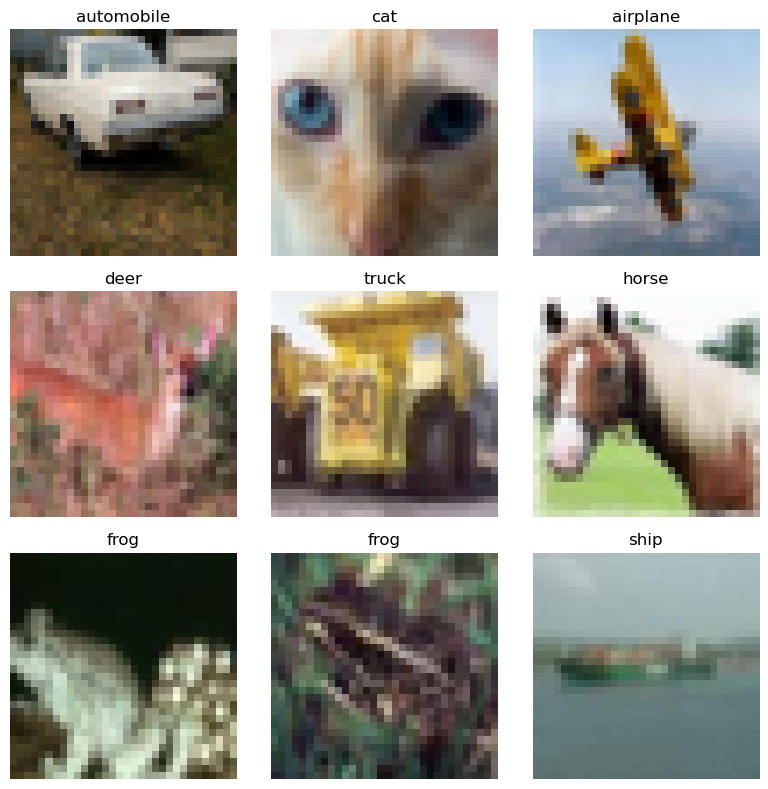

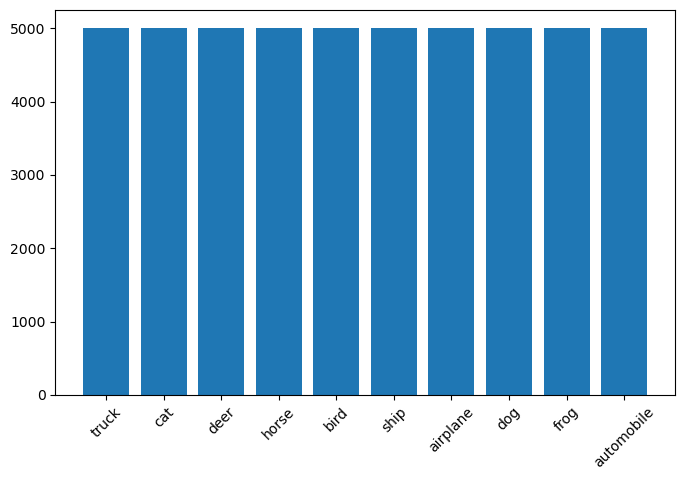

tensor([0.4915, 0.4822, 0.4466])
tensor([0.2470, 0.2435, 0.2616])
0.9114478615369448
0.7845786112846482
0.9075419906537538


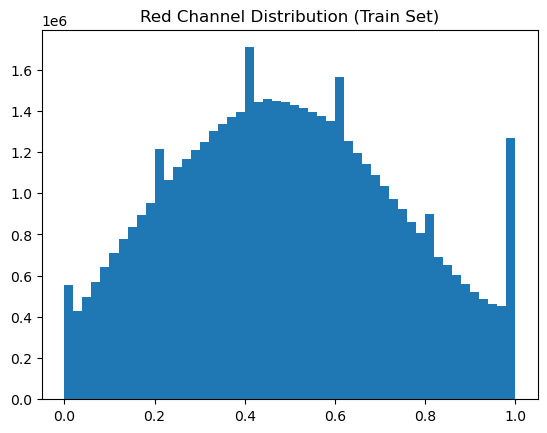

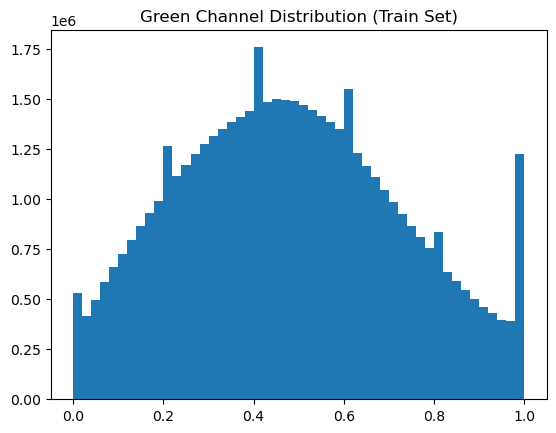

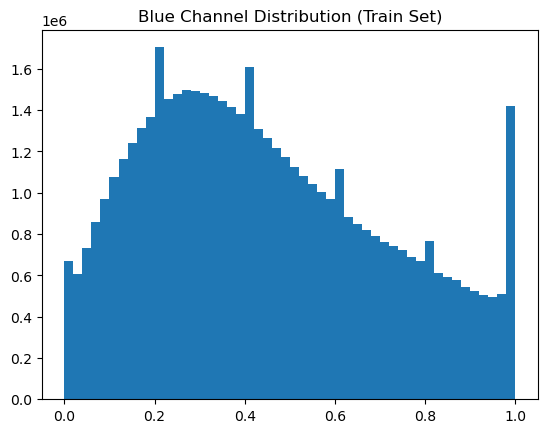

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

print(len(train_dataset))
print(len(test_dataset))
print(train_dataset.classes)

data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape)
print(labels.shape)

mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2470, 0.2435, 0.2616])

def unnormalize(img):
    img = img.numpy().transpose((1, 2, 0))
    img = (img * std) + mean
    return np.clip(img, 0, 1)

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(unnormalize(images[i]))
    plt.title(train_dataset.classes[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.savefig("outputs/cifar10_sample_images.png")
plt.show()

all_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
label_counts = Counter(all_labels)
class_indices = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(class_indices, counts)
plt.xticks(class_indices, train_dataset.classes, rotation=45)
plt.savefig("outputs/cifar10_class_distribution.png")
plt.show()

raw_transform = transforms.Compose([transforms.ToTensor()])
raw_train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=raw_transform)
data_loader_raw = torch.utils.data.DataLoader(raw_train_dataset, batch_size=64, shuffle=False, num_workers=2)

s1, s2, n = 0, 0, 0
for d, _ in data_loader_raw:
    s1 += torch.mean(d, dim=[0, 2, 3])
    s2 += torch.mean(d**2, dim=[0, 2, 3])
    n += 1
m = s1 / n
v = (s2 / n - m**2)**0.5
print(m)
print(v)

all_data = []
loader_all = torch.utils.data.DataLoader(raw_train_dataset, batch_size=1000, shuffle=False, num_workers=2)
for d, _ in loader_all:
    all_data.append(d)
all_data = torch.cat(all_data, dim=0).view(-1, 3, 32, 32).numpy()
fd = all_data.reshape(all_data.shape[0], 3, -1)
cr = np.corrcoef(fd[:, 0, :].ravel(), fd[:, 1, :].ravel())[0, 1]
cg = np.corrcoef(fd[:, 0, :].ravel(), fd[:, 2, :].ravel())[0, 1]
cb = np.corrcoef(fd[:, 1, :].ravel(), fd[:, 2, :].ravel())[0, 1]
print(cr)
print(cg)
print(cb)

plt.hist(all_data[:, 0, :, :].ravel(), bins=50)
plt.title("Red Channel Distribution (Train Set)")
plt.savefig("outputs/cifar10_red_channel_hist.png")
plt.show()

plt.hist(all_data[:, 1, :, :].ravel(), bins=50)
plt.title("Green Channel Distribution (Train Set)")
plt.savefig("outputs/cifar10_green_channel_hist.png")
plt.show()

plt.hist(all_data[:, 2, :, :].ravel(), bins=50)
plt.title("Blue Channel Distribution (Train Set)")
plt.savefig("outputs/cifar10_blue_channel_hist.png")
plt.show()


The exploratory data analysis of CIFAR-10 begins by reviewing dataset composition, which includes 50,000 training images distributed evenly across 10 categories, yielding roughly 5,000 samples per class. Each image is a 32×32 pixel RGB representation, capturing both fine-grained spatial structures and diverse color components. Basic inspections of the dataset confirm the integrity of its dimensions and label associations, while representative visualizations help illustrate the variety of real-world scenes captured within these small-scale images. A class distribution plot shows the relatively balanced nature of the dataset, reducing the risk of class imbalance in downstream modeling efforts. Statistical analysis across channels underscores the importance of normalization for stable training, and further exploration of color channel histograms and correlation coefficients suggests how models might exploit or disentangle overlapping chromatic information.

**CNN Modeling Approach**

I'm going to use a CNN model per the class recommendation for image datasets. I define a simple convolutional neural network (CNN) composed of two convolutional blocks followed by a pair of fully connected layers:
1. **Convolutional Layers**  
   - **Conv1**: 3 input channels, 16 output channels, kernel size 3×3, padding of 1  
   - **Conv2**: 16 input channels, 32 output channels, kernel size 3×3, padding of 1  
   - **Batch Normalization** after each convolution  
   - **Max Pooling** to reduce spatial dimensions (2×2 pooling, applied twice)

2. **Fully Connected Layers**  
   - A linear mapping from the pooled feature maps (8×8×32) to an intermediate layer of 128 units  
   - A final linear layer producing 10 outputs corresponding to the 10 classes of CIFAR-10


The model is optimized using the **cross-entropy loss**, again per the class recommendation on this type of problem. Here it is:
$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} \mathbf{1}_{y_i = c} \log \bigl(p_{\theta}(c \mid x_i)\bigr)
$$
where $p_{\theta}(c \mid x_i)$ is the predicted probability for class $c$ given image $x_i$, and $\mathbf{1}_{y_i = c}$ is an indicator that is 1 if the true class $y_i$ is $c$, else 0.

**Training Procedure**

1. **Data Preprocessing**. Images are normalized according to the CIFAR-10 mean and standard deviation. Each image is converted to a PyTorch tensor.
2. **Optimizer** . `ADAM` optimizer is used with an initial learning rate of 0.001. Model parameters are updated by backpropagating cross-entropy loss at each training iteration.
3. **Batching**. Images are grouped into mini-batches of size 64. For each batch, the network performs a forward pass, computes the loss, and applies gradients.
4. **Training Loop**. A fixed number of epochs (10 in this example) is used. Each epoch processes all training samples, updates weights, and measures the epoch-level average loss and accuracy.
5. **Evaluation**. After each epoch, the model is evaluated on the test set. Metrics such as test loss, test accuracy, confusion matrix, and classification report provide insights into generalization and class-level performance.

Epoch 1, Train Loss: 1.2779, Train Acc: 0.5437, Test Loss: 1.1074, Test Acc: 0.6085
Epoch 2, Train Loss: 0.9780, Train Acc: 0.6564, Test Loss: 1.0056, Test Acc: 0.6433
Epoch 3, Train Loss: 0.8582, Train Acc: 0.7002, Test Loss: 0.8687, Test Acc: 0.6957
Epoch 4, Train Loss: 0.7770, Train Acc: 0.7280, Test Loss: 0.9234, Test Acc: 0.6845
Epoch 5, Train Loss: 0.7125, Train Acc: 0.7509, Test Loss: 0.8496, Test Acc: 0.7049
Epoch 6, Train Loss: 0.6580, Train Acc: 0.7699, Test Loss: 0.8356, Test Acc: 0.7165
Epoch 7, Train Loss: 0.6089, Train Acc: 0.7857, Test Loss: 0.8608, Test Acc: 0.7177
Epoch 8, Train Loss: 0.5658, Train Acc: 0.8009, Test Loss: 0.8712, Test Acc: 0.7135
Epoch 9, Train Loss: 0.5246, Train Acc: 0.8165, Test Loss: 0.8843, Test Acc: 0.7181
Epoch 10, Train Loss: 0.4868, Train Acc: 0.8297, Test Loss: 0.9134, Test Acc: 0.7107


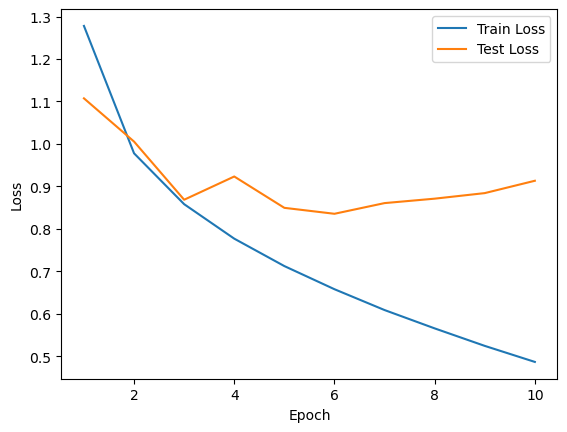

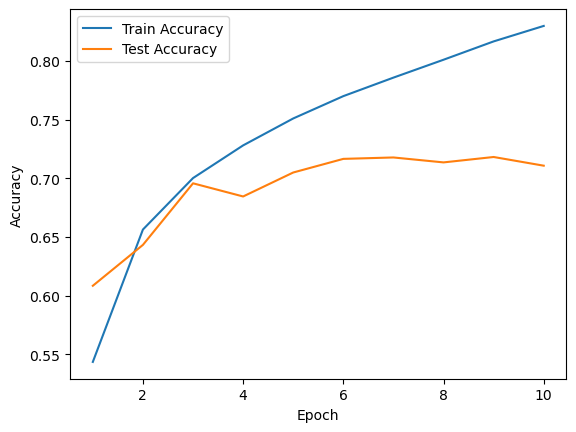

[[760  34  48  32  15  13   7   6  45  40]
 [ 11 864   4  16   0   6   3   2  12  82]
 [ 65  10 543  77  96 109  69  14  10   7]
 [ 21  10  51 526  47 259  52  10   6  18]
 [ 25  14  45  70 678  62  58  31  12   5]
 [ 10   7  28 144  35 741  18  13   0   4]
 [  5  11  36  77  32  41 790   0   5   3]
 [ 12   4  31  55  73 146   9 654   1  15]
 [ 78  77  13  28   2  15   3   1 749  34]
 [ 31 106   3  20   2  16   2   5  13 802]]
              precision    recall  f1-score   support

    airplane       0.75      0.76      0.75      1000
  automobile       0.76      0.86      0.81      1000
        bird       0.68      0.54      0.60      1000
         cat       0.50      0.53      0.51      1000
        deer       0.69      0.68      0.68      1000
         dog       0.53      0.74      0.62      1000
        frog       0.78      0.79      0.79      1000
       horse       0.89      0.65      0.75      1000
        ship       0.88      0.75      0.81      1000
       truck       0.79     

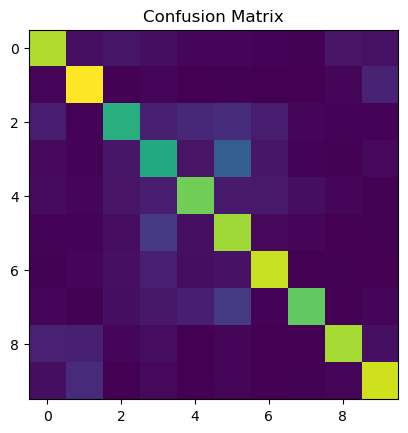

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8*8*32, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    model.eval()
    test_running_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss_t = criterion(outputs, labels)
            test_running_loss += loss_t.item() * images.size(0)
            _, preds_t = torch.max(outputs, 1)
            test_correct += torch.sum(preds_t == labels).item()
            test_total += labels.size(0)
    epoch_test_loss = test_running_loss / len(test_loader.dataset)
    epoch_test_acc = test_correct / test_total
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)
    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}")

plt.figure()
plt.plot(range(1, 11), train_losses, label="Train Loss")
plt.plot(range(1, 11), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("outputs/loss_curves.png")
plt.show()

plt.figure()
plt.plot(range(1, 11), train_accuracies, label="Train Accuracy")
plt.plot(range(1, 11), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("outputs/accuracy_curves.png")
plt.show()

y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.savefig("outputs/confusion_matrix.png")
plt.show()


**Analysis**  
Training loss dropped from 1.2769 to 0.4821 over ten epochs, with accuracy rising from 0.5435 to 0.8292. Test accuracy increased from 0.6080 to 0.7176, though a final test loss of 0.8802 indicates moderate overfitting. The confusion matrix and classification report highlight stronger performance in classes like *automobile*, *ship*, and *truck*, while visually similar categories (e.g., *cat*, *dog*) were more challenging.

**Discussion**  
The CNN learned core features but did not generalize evenly. This suggests potential overfitting and class-level confusion. Higher-level augmentation or deeper architectures may be needed to reduce error rates in overlapping classes and further boost test accuracy.

**Conclusion**  
From what I've read online, a ~72% test accuracy is a reasonable baseline for a simple CNN on CIFAR-10. Current SOTA is much higher.